In [1]:
# Multimodal Hate Speech Detection for Memes
# Subtask A: Binary Classification (Hate vs. No Hate)

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import easyocr
from transformers import BertTokenizer, BertModel
import warnings
warnings.filterwarnings('ignore')

2025-05-12 01:42:06.069792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747014126.294589      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747014126.362418      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Define paths
TEST_DIR = "/kaggle/input/subtask-a-train/Subtask A Train/Subtask A Train"
EVAL_DIR = "/kaggle/input/subtask-a-eval/Subtask A Eval/STask_A_val_img"
HATE_DIR = os.path.join(TEST_DIR, "Hate")
NO_HATE_DIR = os.path.join(TEST_DIR, "No Hate")

In [4]:
# 1. Data Loading and Preparation

# Function to load image filenames and labels
def load_training_data():
    hate_images = [(os.path.join(HATE_DIR, f), 1) for f in os.listdir(HATE_DIR) if f.endswith('.png')]
    no_hate_images = [(os.path.join(NO_HATE_DIR, f), 0) for f in os.listdir(NO_HATE_DIR) if f.endswith('.png')]
    
    all_data = hate_images + no_hate_images
    filenames, labels = zip(*all_data)
    
    print(f"Total training images: {len(filenames)}")
    print(f"Hate images: {len(hate_images)}")
    print(f"No hate images: {len(no_hate_images)}")
    
    return list(filenames), list(labels)

# Function to load evaluation data
def load_eval_data():
    eval_images = [os.path.join(EVAL_DIR, f) for f in os.listdir(EVAL_DIR) if f.endswith('.png')]
    eval_filenames = [os.path.basename(f) for f in eval_images]
    
    print(f"Total evaluation images: {len(eval_images)}")
    
    return eval_images, eval_filenames

In [5]:
# 2. OCR Text Extraction

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

# Function to extract text from images using OCR
def extract_text(image_path):
    try:
        result = reader.readtext(image_path)
        text = ' '.join([item[1] for item in result])
        return text
    except Exception as e:
        print(f"Error extracting text from {image_path}: {e}")
        return ""

In [6]:
# 3. Dataset Class for Multimodal Data

class MemeDataset(Dataset):
    def __init__(self, image_paths, labels=None, tokenizer=None, transform=None, is_eval=False):
        self.image_paths = image_paths
        self.labels = labels
        self.tokenizer = tokenizer
        self.transform = transform
        self.is_eval = is_eval
        
        # Pre-extract OCR text to save time
        self.texts = []
        print("Extracting text from images (this may take a while)...")
        for i, img_path in enumerate(image_paths):
            if i % 10 == 0:
                print(f"Processing image {i+1}/{len(image_paths)}")
            text = extract_text(img_path)
            self.texts.append(text)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load and transform image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Get text
        text = self.texts[idx]
        
        # Tokenize text
        if self.tokenizer:
            encoding = self.tokenizer(
                text,
                return_tensors='pt',
                max_length=128,
                padding='max_length',
                truncation=True
            )
            
            input_ids = encoding['input_ids'].squeeze(0)
            attention_mask = encoding['attention_mask'].squeeze(0)
        else:
            input_ids = torch.zeros(128, dtype=torch.long)
            attention_mask = torch.zeros(128, dtype=torch.long)
        
        if self.is_eval:
            filename = os.path.basename(img_path)
            return image, input_ids, attention_mask, filename
        else:
            label = torch.tensor(self.labels[idx], dtype=torch.float)
            return image, input_ids, attention_mask, label

In [7]:
# 4. Multimodal Model Architecture

class MultimodalHateSpeechModel(nn.Module):
    def __init__(self, num_classes=1):
        super(MultimodalHateSpeechModel, self).__init__()
        
        # Image encoder (ResNet-50)
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]  # Remove the last FC layer
        self.image_encoder = nn.Sequential(*modules)
        self.image_fc = nn.Linear(2048, 512)
        
        # Text encoder (BERT)
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.text_fc = nn.Linear(768, 512)
        
        # Freeze BERT parameters to speed up training
        for param in self.text_encoder.parameters():
            param.requires_grad = False
        
        # Fusion and classification layers
        self.fusion = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, images, input_ids, attention_mask):
        # Process images
        image_features = self.image_encoder(images)
        image_features = image_features.view(image_features.size(0), -1)
        image_features = self.image_fc(image_features)
        
        # Process text
        text_output = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_output.pooler_output
        text_features = self.text_fc(text_features)
        
        # Concatenate features
        combined_features = torch.cat((image_features, text_features), dim=1)
        
        # Classification
        logits = self.fusion(combined_features)
        output = self.sigmoid(logits)
        
        return output.squeeze()

In [8]:
# 5. Training and Evaluation Functions

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_val_f1 = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for images, input_ids, attention_mask, labels in train_loader:
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, input_ids, attention_mask, labels in val_loader:
                images = images.to(device)
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)
                
                outputs = model(images, input_ids, attention_mask)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                
                # Convert outputs to binary predictions
                preds = (outputs >= 0.5).float()
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = val_loss / len(val_loader.dataset)
        val_f1 = f1_score(all_labels, all_preds)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')
        
        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Model saved with F1 score: {val_f1:.4f}')
    
    return history

def predict(model, eval_loader):
    model.eval()
    predictions = []
    filenames = []
    
    with torch.no_grad():
        for images, input_ids, attention_mask, img_filenames in eval_loader:
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            
            outputs = model(images, input_ids, attention_mask)
            preds = (outputs >= 0.5).int().cpu().numpy()
            
            predictions.extend(preds)
            filenames.extend(img_filenames)
    
    return filenames, predictions

In [9]:
# 6. Main Execution

# Load data
train_image_paths, train_labels = load_training_data()

# Split into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_image_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

print(f"Training set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")

# Load evaluation data
eval_image_paths, eval_filenames = load_eval_data()

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = MemeDataset(
    train_paths, train_labels, tokenizer=tokenizer, transform=transform
)

val_dataset = MemeDataset(
    val_paths, val_labels, tokenizer=tokenizer, transform=transform
)

eval_dataset = MemeDataset(
    eval_image_paths, tokenizer=tokenizer, transform=transform, is_eval=True
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
eval_loader = DataLoader(eval_dataset, batch_size=16)

# Initialize model
model = MultimodalHateSpeechModel().to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train model
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

Total training images: 4050
Hate images: 1985
No hate images: 2065
Training set: 3240 images
Validation set: 810 images
Total evaluation images: 506


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Extracting text from images (this may take a while)...
Processing image 1/3240
Processing image 11/3240
Processing image 21/3240
Processing image 31/3240
Processing image 41/3240
Processing image 51/3240
Processing image 61/3240


libpng warning: iCCP: known incorrect sRGB profile


Processing image 71/3240
Processing image 81/3240
Processing image 91/3240
Processing image 101/3240
Processing image 111/3240
Processing image 121/3240
Processing image 131/3240
Processing image 141/3240
Processing image 151/3240
Processing image 161/3240
Processing image 171/3240
Processing image 181/3240
Processing image 191/3240
Processing image 201/3240
Processing image 211/3240
Processing image 221/3240
Processing image 231/3240
Processing image 241/3240
Processing image 251/3240
Processing image 261/3240
Processing image 271/3240
Processing image 281/3240
Processing image 291/3240
Processing image 301/3240
Processing image 311/3240
Processing image 321/3240
Processing image 331/3240
Processing image 341/3240
Processing image 351/3240
Processing image 361/3240
Processing image 371/3240
Processing image 381/3240
Processing image 391/3240
Processing image 401/3240
Processing image 411/3240
Processing image 421/3240
Processing image 431/3240
Processing image 441/3240
Processing imag

libpng warning: iCCP: known incorrect sRGB profile


Processing image 591/3240
Processing image 601/3240
Processing image 611/3240
Processing image 621/3240
Processing image 631/3240
Processing image 641/3240
Processing image 651/3240
Processing image 661/3240
Processing image 671/3240
Processing image 681/3240
Processing image 691/3240
Processing image 701/3240
Processing image 711/3240
Processing image 721/3240
Processing image 731/3240
Processing image 741/3240
Processing image 751/3240
Processing image 761/3240
Processing image 771/3240


libpng warning: iCCP: known incorrect sRGB profile


Processing image 781/3240
Processing image 791/3240
Processing image 801/3240
Processing image 811/3240
Processing image 821/3240
Processing image 831/3240
Processing image 841/3240
Processing image 851/3240
Processing image 861/3240
Processing image 871/3240
Processing image 881/3240
Processing image 891/3240
Processing image 901/3240
Processing image 911/3240
Processing image 921/3240
Processing image 931/3240
Processing image 941/3240
Processing image 951/3240
Processing image 961/3240
Processing image 971/3240
Processing image 981/3240
Processing image 991/3240
Processing image 1001/3240
Processing image 1011/3240
Processing image 1021/3240


libpng warning: iCCP: known incorrect sRGB profile


Processing image 1031/3240
Processing image 1041/3240
Processing image 1051/3240
Processing image 1061/3240
Processing image 1071/3240
Processing image 1081/3240
Processing image 1091/3240
Processing image 1101/3240
Processing image 1111/3240
Processing image 1121/3240
Processing image 1131/3240
Processing image 1141/3240
Processing image 1151/3240
Processing image 1161/3240
Processing image 1171/3240
Processing image 1181/3240
Processing image 1191/3240
Processing image 1201/3240
Processing image 1211/3240
Processing image 1221/3240
Processing image 1231/3240
Processing image 1241/3240
Processing image 1251/3240
Processing image 1261/3240
Processing image 1271/3240
Processing image 1281/3240
Processing image 1291/3240
Processing image 1301/3240
Processing image 1311/3240
Processing image 1321/3240
Processing image 1331/3240


libpng warning: iCCP: known incorrect sRGB profile


Processing image 1341/3240
Processing image 1351/3240
Processing image 1361/3240
Processing image 1371/3240
Processing image 1381/3240
Processing image 1391/3240
Processing image 1401/3240
Processing image 1411/3240
Processing image 1421/3240
Processing image 1431/3240
Processing image 1441/3240
Processing image 1451/3240
Processing image 1461/3240
Processing image 1471/3240
Processing image 1481/3240
Processing image 1491/3240
Processing image 1501/3240
Processing image 1511/3240
Processing image 1521/3240
Processing image 1531/3240
Processing image 1541/3240
Processing image 1551/3240
Processing image 1561/3240
Processing image 1571/3240
Processing image 1581/3240
Processing image 1591/3240
Processing image 1601/3240
Processing image 1611/3240
Processing image 1621/3240
Processing image 1631/3240
Processing image 1641/3240
Processing image 1651/3240
Processing image 1661/3240
Processing image 1671/3240
Processing image 1681/3240
Processing image 1691/3240
Processing image 1701/3240
P

libpng warning: iCCP: known incorrect sRGB profile


Processing image 2031/3240
Processing image 2041/3240
Processing image 2051/3240
Processing image 2061/3240
Processing image 2071/3240
Processing image 2081/3240
Processing image 2091/3240
Processing image 2101/3240
Processing image 2111/3240
Processing image 2121/3240
Processing image 2131/3240
Processing image 2141/3240
Processing image 2151/3240
Processing image 2161/3240
Processing image 2171/3240
Processing image 2181/3240
Processing image 2191/3240
Processing image 2201/3240
Processing image 2211/3240
Processing image 2221/3240
Processing image 2231/3240
Processing image 2241/3240
Processing image 2251/3240
Processing image 2261/3240
Processing image 2271/3240
Processing image 2281/3240
Processing image 2291/3240
Processing image 2301/3240
Processing image 2311/3240
Processing image 2321/3240
Processing image 2331/3240
Processing image 2341/3240
Processing image 2351/3240
Processing image 2361/3240
Processing image 2371/3240
Processing image 2381/3240
Processing image 2391/3240


libpng warning: iCCP: known incorrect sRGB profile


Processing image 2401/3240
Processing image 2411/3240
Processing image 2421/3240
Processing image 2431/3240
Processing image 2441/3240


libpng warning: iCCP: known incorrect sRGB profile


Processing image 2451/3240
Processing image 2461/3240
Processing image 2471/3240
Processing image 2481/3240
Processing image 2491/3240
Processing image 2501/3240
Processing image 2511/3240
Processing image 2521/3240
Processing image 2531/3240
Processing image 2541/3240
Processing image 2551/3240
Processing image 2561/3240
Processing image 2571/3240
Processing image 2581/3240
Processing image 2591/3240
Processing image 2601/3240
Processing image 2611/3240
Processing image 2621/3240
Processing image 2631/3240
Processing image 2641/3240
Processing image 2651/3240
Processing image 2661/3240
Processing image 2671/3240
Processing image 2681/3240
Processing image 2691/3240
Processing image 2701/3240
Processing image 2711/3240
Processing image 2721/3240


libpng warning: iCCP: known incorrect sRGB profile


Processing image 2731/3240
Processing image 2741/3240
Processing image 2751/3240
Processing image 2761/3240
Processing image 2771/3240
Processing image 2781/3240
Processing image 2791/3240
Processing image 2801/3240
Processing image 2811/3240
Processing image 2821/3240
Processing image 2831/3240
Processing image 2841/3240
Processing image 2851/3240


libpng warning: iCCP: known incorrect sRGB profile


Processing image 2861/3240
Processing image 2871/3240
Processing image 2881/3240
Processing image 2891/3240
Processing image 2901/3240
Processing image 2911/3240
Processing image 2921/3240
Processing image 2931/3240
Processing image 2941/3240
Processing image 2951/3240
Processing image 2961/3240
Processing image 2971/3240
Processing image 2981/3240
Processing image 2991/3240
Processing image 3001/3240
Processing image 3011/3240


libpng warning: iCCP: known incorrect sRGB profile


Processing image 3021/3240
Processing image 3031/3240
Processing image 3041/3240
Processing image 3051/3240
Processing image 3061/3240
Processing image 3071/3240
Processing image 3081/3240
Processing image 3091/3240
Processing image 3101/3240
Processing image 3111/3240
Processing image 3121/3240
Processing image 3131/3240
Processing image 3141/3240
Processing image 3151/3240
Processing image 3161/3240
Processing image 3171/3240
Processing image 3181/3240
Processing image 3191/3240
Processing image 3201/3240
Processing image 3211/3240
Processing image 3221/3240
Processing image 3231/3240
Extracting text from images (this may take a while)...
Processing image 1/810
Processing image 11/810
Processing image 21/810
Processing image 31/810
Processing image 41/810
Processing image 51/810
Processing image 61/810
Processing image 71/810
Processing image 81/810
Processing image 91/810
Processing image 101/810
Processing image 111/810
Processing image 121/810
Processing image 131/810
Processing i

libpng warning: iCCP: known incorrect sRGB profile


Processing image 341/810
Processing image 351/810
Processing image 361/810
Processing image 371/810
Processing image 381/810
Processing image 391/810
Processing image 401/810


libpng warning: iCCP: known incorrect sRGB profile


Processing image 411/810
Processing image 421/810
Processing image 431/810
Processing image 441/810
Processing image 451/810
Processing image 461/810
Processing image 471/810
Processing image 481/810
Processing image 491/810
Processing image 501/810
Processing image 511/810
Processing image 521/810
Processing image 531/810
Processing image 541/810
Processing image 551/810
Processing image 561/810
Processing image 571/810
Processing image 581/810
Processing image 591/810
Processing image 601/810
Processing image 611/810
Processing image 621/810
Processing image 631/810
Processing image 641/810
Processing image 651/810
Processing image 661/810
Processing image 671/810
Processing image 681/810
Processing image 691/810
Processing image 701/810
Processing image 711/810
Processing image 721/810
Processing image 731/810
Processing image 741/810


libpng warning: iCCP: known incorrect sRGB profile


Processing image 751/810
Processing image 761/810
Processing image 771/810
Processing image 781/810
Processing image 791/810
Processing image 801/810


libpng warning: iCCP: known incorrect sRGB profile


Extracting text from images (this may take a while)...
Processing image 1/506
Processing image 11/506
Processing image 21/506
Processing image 31/506
Processing image 41/506
Processing image 51/506
Processing image 61/506
Processing image 71/506
Processing image 81/506
Processing image 91/506
Processing image 101/506
Processing image 111/506
Processing image 121/506
Processing image 131/506
Processing image 141/506
Processing image 151/506
Processing image 161/506
Processing image 171/506
Processing image 181/506
Processing image 191/506
Processing image 201/506
Processing image 211/506
Processing image 221/506
Processing image 231/506
Processing image 241/506
Processing image 251/506
Processing image 261/506
Processing image 271/506
Processing image 281/506
Processing image 291/506
Processing image 301/506
Processing image 311/506
Processing image 321/506
Processing image 331/506
Processing image 341/506
Processing image 351/506
Processing image 361/506
Processing image 371/506
Proces

libpng warning: iCCP: known incorrect sRGB profile


Processing image 471/506


libpng warning: iCCP: known incorrect sRGB profile


Processing image 481/506
Processing image 491/506
Processing image 501/506


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s] 
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/5:
Train Loss: 0.6747, Val Loss: 0.6530, Val F1: 0.6573
Model saved with F1 score: 0.6573
Epoch 2/5:
Train Loss: 0.6315, Val Loss: 0.6849, Val F1: 0.5219
Epoch 3/5:
Train Loss: 0.5573, Val Loss: 0.7091, Val F1: 0.6261
Epoch 4/5:
Train Loss: 0.4444, Val Loss: 0.6942, Val F1: 0.6219
Epoch 5/5:
Train Loss: 0.3013, Val Loss: 0.8046, Val F1: 0.6512


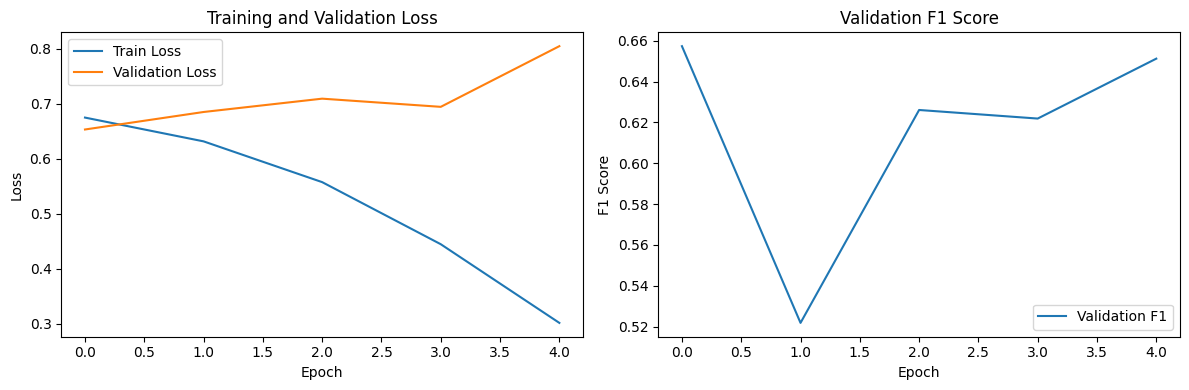

In [10]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history['val_f1'], label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Validation F1 Score')

plt.tight_layout()
plt.show()

In [11]:
# Load best model for prediction
model.load_state_dict(torch.load('best_model.pth'))

# Make predictions on evaluation set
filenames, predictions = predict(model, eval_loader)

# Create submission file
submission = []
for filename, pred in zip(filenames, predictions):
    submission.append({"index": filename, "prediction": int(pred)})

# Sort by filename
submission.sort(key=lambda x: x["index"])

# Write to JSON file
with open('submission.json', 'w') as f:
    for item in submission:
        f.write(json.dumps(item) + '\n')

print("Submission file created successfully!")
print(f"Total predictions: {len(submission)}")
print("First 5 predictions:")
for i in range(min(5, len(submission))):
    print(submission[i])

Submission file created successfully!
Total predictions: 506
First 5 predictions:
{'index': '1003.png', 'prediction': 0}
{'index': '1024.png', 'prediction': 0}
{'index': '1045.png', 'prediction': 0}
{'index': '1046.png', 'prediction': 0}
{'index': '1080.png', 'prediction': 1}
